# Regresión lineal sobre precios de casas utilizando *TensorFlow* y normalización de variables de entrenamiento

In [3]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

### Cargamos los datos del proyecto

En el proyecto se concluyó que la variable *OverallQual* generaba un menor de la función de costo. Por lo tanto, en esta tarea se utilizará dicha variable para efectuar la regresión lineal simple. 

In [6]:
data = np.load("proyecto_training_data.npy")
# Cantidad de datos y regresoras
OBS, NVAR = data.shape
(OBS, NVAR)

# Dividir el conjunto de datos
TRAINOBS = int(OBS*0.8)

# Conjunto de datos de entrenamiento
Ytrain = data[:TRAINOBS, 0]
Xtrain = data[:TRAINOBS, 1]
print("Entrenamiento: ", Ytrain.shape, Xtrain.shape)

# Conjunto de datos de validación y pruebas
Ytest = data[TRAINOBS:, 0]
Xtest = data[TRAINOBS:, 1]
print("Prueba: ", Ytest.shape, Xtest.shape)

Entrenamiento:  (1168,) (1168,)
Prueba:  (292,) (292,)


## Gráfica de los datos

Vamos a graficar los datos nuevamente, para observar el modelo final obtenido con TensorFlow

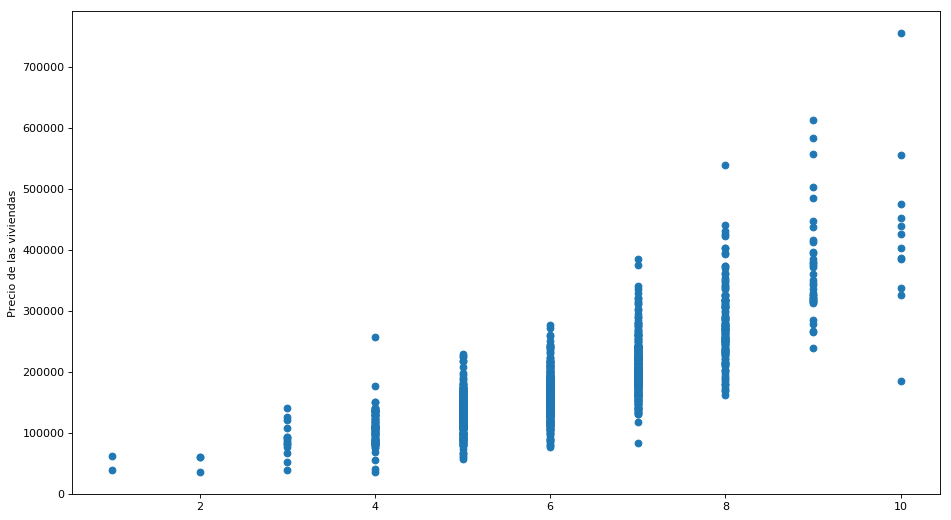

In [7]:
fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xtrain, Ytrain)
#plt.title("Gráfica de modelos en función del número de iteración.")
plt.ylabel("Precio de las viviendas");

## Normalización de las variables para el proceso de entrenamiento

In [8]:
def normalizar(x):
    # Obtener la media
    x_mean = np.mean(x)
    # Obtener la desviación
    x_sd = np.std(x)
    # Normalizar la variable
    y = (x - x_mean) / x_sd
    
    return (y, x_mean, x_sd)

def escalar(x):
    return x/1000

In [9]:
# Normalizando valores de X e Y
Ytrain = escalar(Ytrain)
Xtrain, Xtrain_mean, Xtrain_sd = normalizar(Xtrain)

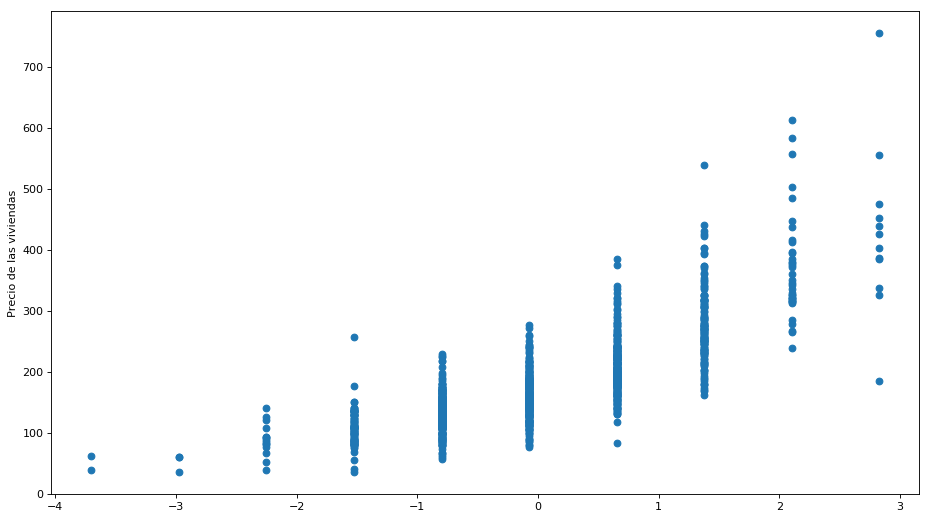

In [17]:
# Graficamos nuevamente X e Y
fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xtrain, Ytrain)
#plt.title("Gráfica de modelos en función del número de iteración.")
plt.ylabel("Precio de las viviendas");

## Construcción del modelo en TensorFlow

En esta sección construiremos el modelo a través de un grafo en TensorFlow. Para esto, construiremos la función de hipótesis, la función de costo y el optimizador (a través de gradiente en descenso de TensorFlow). Finalmente, inicializaremos los parámetros entrenables del modelo. 

In [69]:
# Crear un grafo específico
g = tf.Graph()
# Definimos tensores y operaciones en g
with g.as_default():
    # Creando los placeholders
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")

    # Declaramos las variables entrenables de TensorFlow
    # para la pendiente y el intersecto (bias) de la regresión lineal
    # Se inicializan las variables igual que en el proyecto, pendiente = 1, intersecto = 0
    W = tf.Variable(tf.constant(1.), name = "W") 
    b = tf.Variable(tf.constant(0.), name = "b") 

    # Hiperparámetros del modelo
    lr = tf.placeholder(tf.float32, name="lr")
    
    # Función de pronóstico o hipótesis
    with tf.name_scope("Hipotesis"):
        Yhat = tf.add(tf.multiply(X, W), b, name = "Yhat") 

    # Función de costo
    with tf.name_scope("FuncionDeCosto"):
        #cost = tf.reduce_sum(tf.pow(Yhat-Y, 2)) / (2 * TRAINOBS) 
        cost = tf.divide( tf.reduce_mean(tf.pow(Yhat-Y, 2)), 2., name="fCosto")

    # Gradient Descent Optimizer 
    with tf.name_scope("GradientDes.Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost) 

    # Global Variables Initializer 
    init = tf.global_variables_initializer() 

    # Summary para el TensorBoard
    testSummary = tf.summary.scalar(name='Funcion_de_costo', tensor = cost)
    

## Proceso de entrenamiento 

Ahora se realizará el entrenamiento del modelo utilizando un objeto *TensorFlow.Session* para llevar a cabo la evaluación de los nodos correspondientes.

In [70]:
def entrenarModeloLineal(x, y, training_epochs, learning_rate, imprimirCada):
    # Starting the Tensorflow Session 
    with tf.Session(graph = g) as sess: 

        # Crear el writer
        writer = tf.summary.FileWriter('./orderedGraph/lr='+str(learning_rate), sess.graph)
        # Initializing the Variables 
        sess.run(init) 

        # Iterating through all the epochs 
        for epoch in range(training_epochs): 

            # Feeding each data point into the optimizer using Feed Dictionary 
            #for (_x, _y) in zip(x, y): 
            sess.run(optimizer, feed_dict = {X : x, Y : y, lr : learning_rate}) 

            # Displaying the result after every 50 epochs 
            if (epoch + 1) % imprimirCada == 0: 
                # Calculating the cost a every epoch 
                c = sess.run(cost, feed_dict = {X : Xtrain, Y : Ytrain}) 
                print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b)) 

            # Ejecutar el summary 
            summary = sess.run(testSummary, feed_dict = {X : x, Y : y})
            # Agregarlo al tablero
            writer.add_summary(summary, epoch)


        # Cerrar el writer
        writer.close()
        
        # Storing necessary values to be used outside the Session 
        training_cost = sess.run(cost, feed_dict ={X: x, Y: y}) 
        weight = sess.run(W) 
        bias = sess.run(b) 
        
    return (weight, bias, training_cost)


## Hipótesis respecto a los diferentes valores del hiperparámetro *learning rate*

Los valores de *learning rate* a probar son los siguientes: 

    10, 1, 0.1, 0.01, 0.001, 0.0001
    
**Hipótesis**: 
* De forma preliminar, se podría pensar que los valores muy grandes (10 y 1) podrían alejarnos del mínimo en la función de costo. Posiblemente los saltos en el gradiente en descenso serían muy grandes, y por lo tanto, el costo probablemente aumentaría en este caso.

* Respecto a los valores muy pequeños (0.001 y 0.0001), es posible que con estos valores los pasos sean demasiado pequeños en la función de costo, y por lo tanto, podría ser que requieran muchas más iteraciones para converger al mínimo.

* Respecto a los valores del centro (0.1, 0.01) podrían ser valores ideales para la convergencia del mínimo en la función de costo. 

Para probar la hipótesis acerca de los valores se utilizará la **misma cantidad de *epochs*** de entrenamiento para solamente observar el efecto del *learning rate* en el proceso de entrenamiento.

In [71]:
# Función para graficar modelo resultante
def graficarModelo(weight, bias, costo):
    # Calcular los valores ajustados
    predictions = weight * Xtrain + bias 
    
    # Reescalar las variables a sus niveles para generar la gráfica
    x = (Xtrain * Xtrain_sd) + Xtrain_mean
    y = Ytrain*1000
    predictions = predictions * 1000
    
    # Obtener la pendiente y el intersecto en la escala de los datos
    pend = 1000 * weight / Xtrain_mean
    intersecto = 1000 * (bias - (weight * Xtrain_mean / Xtrain_sd))
    print("Costo = ", costo, "Pendiente = ", pend, "Intercepto = ", intersecto, '\n') 

    # Grafica del modelo
    fig = plt.figure(figsize=(14, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, label = 'Valores observados')
    plt.ylabel("Precio de las viviendas");
    plt.plot(x, predictions, 'r', label ='Valores ajustados')  
    plt.legend() 
    plt.show() 

## Entrenamiento con learning_rate = 1

In [72]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=1, imprimirCada=10)

Epoch 10 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 20 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 30 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 40 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 50 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 60 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 70 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 80 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 90 : cost = 1146.9161 W = 62.552086 b = 180.59027
Epoch 100 : cost = 1146.9161 W = 62.552086 b = 180.59027


Costo =  1146.9161 Pendiente =  10252.713486347311 Intercepto =  -96469.580212013 



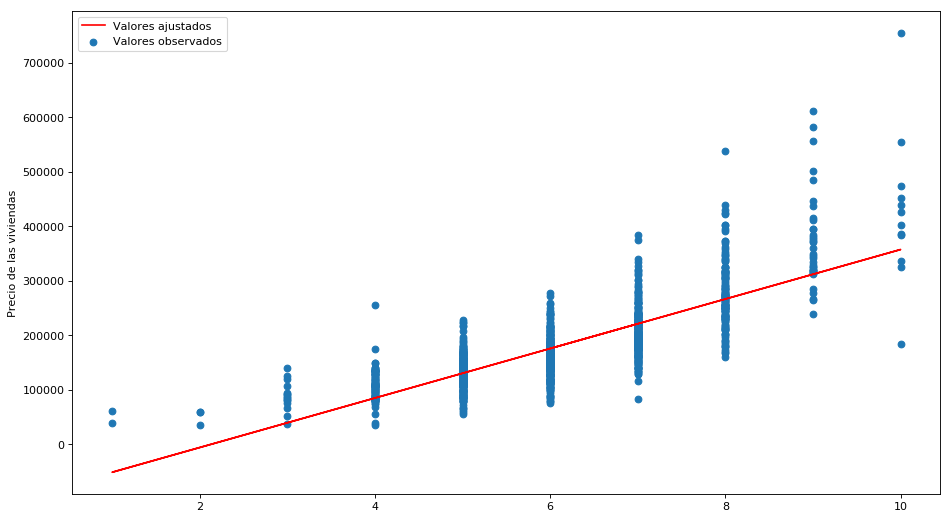

In [73]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 10

In [74]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=10, imprimirCada=10)

Epoch 10 : cost = 2.2127837e+23 W = -214618590000.0 b = -629678900000.0
Epoch 20 : cost = inf W = -7.483295e+20 b = -2.195556e+21
Epoch 30 : cost = inf W = -2.6092615e+30 b = -7.6554496e+30
Epoch 40 : cost = nan W = nan b = nan
Epoch 50 : cost = nan W = nan b = nan
Epoch 60 : cost = nan W = nan b = nan
Epoch 70 : cost = nan W = nan b = nan
Epoch 80 : cost = nan W = nan b = nan
Epoch 90 : cost = nan W = nan b = nan
Epoch 100 : cost = nan W = nan b = nan


Costo =  nan Pendiente =  nan Intercepto =  nan 



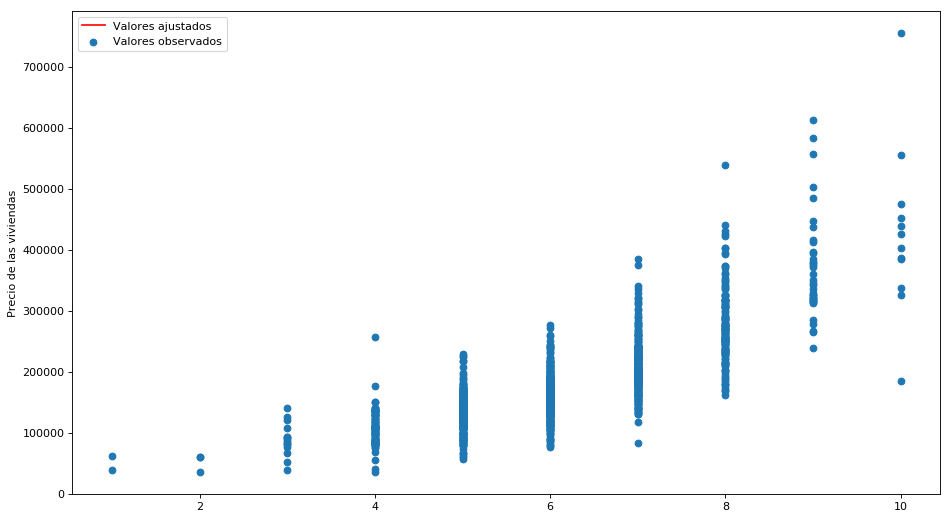

In [75]:
graficarModelo(weight, bias, costo)

En este caso, vemos que la función de costo empieza a crecer desmesuradamente, es por esto que no vemos una recta de regresión final.

## Entrenamiento con learning_rate = 0.1

In [76]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.1, imprimirCada=10)

Epoch 10 : cost = 3359.7036 W = 41.090202 b = 117.62234
Epoch 20 : cost = 1415.9393 W = 55.06879 b = 158.63472
Epoch 30 : cost = 1179.6233 W = 59.94282 b = 172.93483
Epoch 40 : cost = 1150.8927 W = 61.642296 b = 177.92099
Epoch 50 : cost = 1147.3995 W = 62.234863 b = 179.65955
Epoch 60 : cost = 1146.975 W = 62.44148 b = 180.26576
Epoch 70 : cost = 1146.9232 W = 62.51352 b = 180.47713
Epoch 80 : cost = 1146.9171 W = 62.53864 b = 180.55083
Epoch 90 : cost = 1146.9164 W = 62.547398 b = 180.57652
Epoch 100 : cost = 1146.9163 W = 62.550453 b = 180.58548


Costo =  1146.9163 Pendiente =  10252.44587725078 Intercepto =  -96467.13985094328 



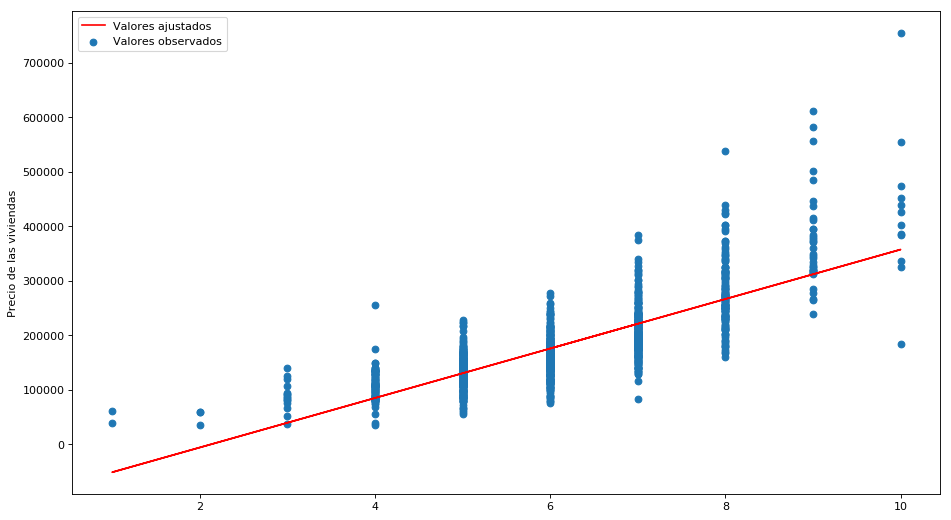

In [77]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.01

In [78]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.01, imprimirCada=10)

Epoch 10 : cost = 16033.44 W = 6.8854823 b = 17.267668
Epoch 20 : cost = 13322.707 W = 12.208206 b = 32.884235
Epoch 30 : cost = 11105.58 W = 17.021986 b = 47.007572
Epoch 40 : cost = 9292.177 W = 21.375483 b = 59.780476
Epoch 50 : cost = 7808.982 W = 25.312706 b = 71.332054
Epoch 60 : cost = 6595.8657 W = 28.873459 b = 81.77909
Epoch 70 : cost = 5603.6514 W = 32.09374 b = 91.2272
Epoch 80 : cost = 4792.1104 W = 35.006104 b = 99.77192
Epoch 90 : cost = 4128.345 W = 37.63999 b = 107.4996
Epoch 100 : cost = 3585.449 W = 40.022034 b = 114.488365


Costo =  3585.449 Pendiente =  6559.884276110371 Intercepto =  -62779.88326661963 



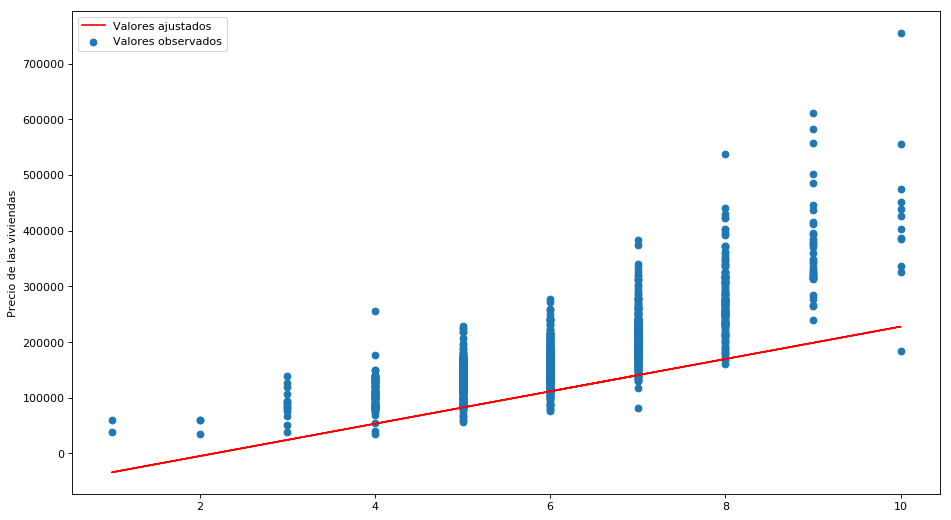

In [79]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.001

In [80]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.001, imprimirCada=10)

Epoch 10 : cost = 18987.094 W = 1.6127584 b = 1.797798
Epoch 20 : cost = 18633.66 W = 2.2194164 b = 3.577699
Epoch 30 : cost = 18287.227 W = 2.8200352 b = 5.3398814
Epoch 40 : cost = 17947.66 W = 3.414675 b = 7.0845203
Epoch 50 : cost = 17614.816 W = 4.0033946 b = 8.811791
Epoch 60 : cost = 17288.568 W = 4.5862546 b = 10.521868
Epoch 70 : cost = 16968.785 W = 5.163312 b = 12.214918
Epoch 80 : cost = 16655.332 W = 5.734624 b = 13.891114
Epoch 90 : cost = 16348.093 W = 6.300249 b = 15.550626
Epoch 100 : cost = 16046.941 W = 6.860243 b = 17.193617


Costo =  16046.941 Pendiente =  1124.4405895814514 Intercepto =  -13192.226144800763 



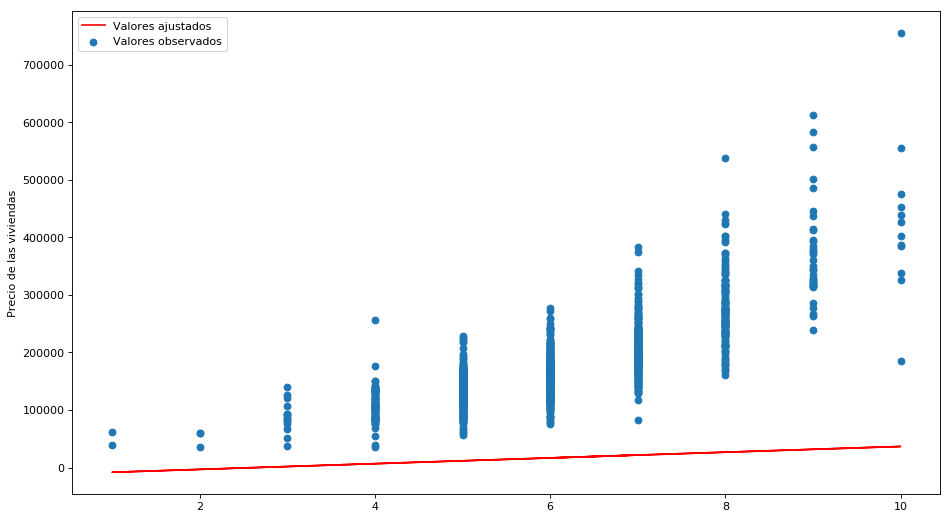

In [81]:
graficarModelo(weight, bias, costo)

## Entrenamiento con learning_rate = 0.0001

In [82]:
weight, bias, costo = entrenarModeloLineal(Xtrain, Ytrain, training_epochs=100, learning_rate=0.0001, imprimirCada=10)

Epoch 10 : cost = 19311.303 W = 1.0615244 b = 0.18050905
Epoch 20 : cost = 19275.01 W = 1.1229874 b = 0.3608377
Epoch 30 : cost = 19238.785 W = 1.1843888 b = 0.54098606
Epoch 40 : cost = 19202.64 W = 1.245729 b = 0.72095436
Epoch 50 : cost = 19166.56 W = 1.3070077 b = 0.9007427
Epoch 60 : cost = 19130.557 W = 1.3682252 b = 1.0803515
Epoch 70 : cost = 19094.625 W = 1.4293816 b = 1.2597808
Epoch 80 : cost = 19058.76 W = 1.4904767 b = 1.4390304
Epoch 90 : cost = 19022.967 W = 1.5515108 b = 1.6181012
Epoch 100 : cost = 18987.256 W = 1.612484 b = 1.7969933


Costo =  18987.256 Pendiente =  264.29712133329974 Intercepto =  -5345.127823730649 



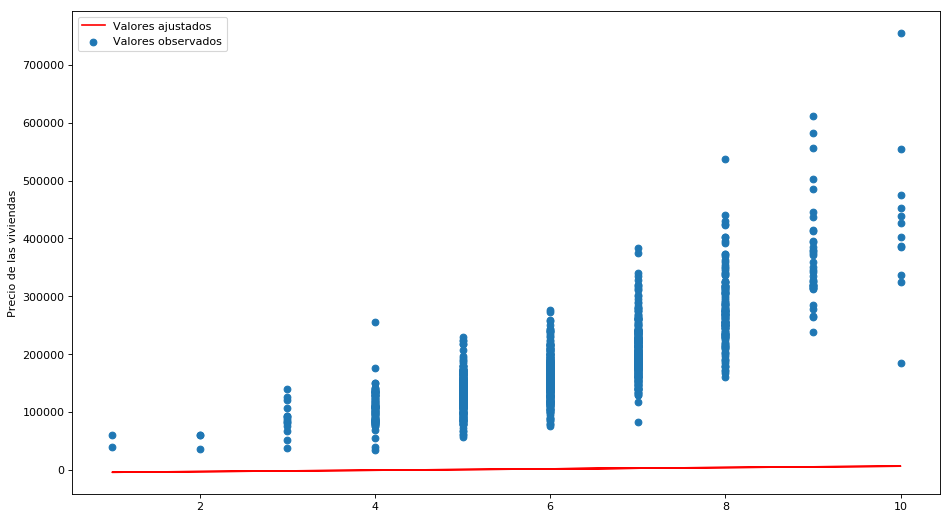

In [83]:
graficarModelo(weight, bias, costo)

## Gráficas del modelo y de la función de costo en *TensorBoard*

<img src="grafoFinalLegible.png">

### Resultados con normalización de variables

<img src="curvasConNormalizacion.png">

## Conclusiones

Como se observa en las gráficas de *TensorBoard*, conforme el *learning rate* es más pequeño, la función de costo disminuye más lentamente en cada epoch. Con el *learning rate* de 10, el error en el primer epoch es muy alto y no aparece en la gráfica. Como se ve en la sección del código del entrenamiento, los valores de la función de costo se hicieron muy grandes, por lo que se descarta su utilización para propósitos de entrenamiento. 

Finalmente, el valor de *learning rate* que generaron un menor valor de costo fueron 1 y 0.1. 